<a href="https://colab.research.google.com/github/jalent27/DataLearnBballSalaryProjection/blob/main/BasketballPlayerSalaryFinalNN_11_23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import kagglehub
import os
import torch.nn as nn
import torch.optim as optim
import torch
import sklearn
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.nn import L1Loss

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [ ]:

# Download latest version
path = kagglehub.dataset_download("jamiewelsh2/nba-player-salaries-2022-23-season")

print("Path to dataset files:", path)



100%|██████████| 72.6k/72.6k [00:00<00:00, 351kB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/jamiewelsh2/nba-player-salaries-2022-23-season/versions/2


In [ ]:


path = '/root/.cache/kagglehub/datasets/jamiewelsh2/nba-player-salaries-2022-23-season/versions/2'
os.listdir(path)


['nba_salaries.csv', 'nba_2022-23_all_stats_with_salary.csv']

In [ ]:

df = pd.read_csv(f"{path}/nba_2022-23_all_stats_with_salary.csv")

df.head()


,Unnamed: 0,Player Name,Salary,Position,Age,Team,GP,GS,MP,FG,...,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
0,0,Stephen Curry,48070014,PG,34,GSW,56,56,34.7,10.0,...,12.5,31.0,5.8,2.0,7.8,0.192,7.5,0.1,7.5,4.7
1,1,John Wall,47345760,PG,32,LAC,34,3,22.2,4.1,...,17.1,27.0,-0.4,0.7,0.3,0.020,-0.8,-0.4,-1.2,0.1
2,2,Russell Westbrook,47080179,PG,34,LAL/LAC,73,24,29.1,5.9,...,18.4,27.7,-0.6,2.6,1.9,0.044,0.3,-0.1,0.2,1.2
3,3,LeBron James,44474988,PF,38,LAL,55,54,35.5,11.1,...,11.6,33.3,3.2,2.4,5.6,0.138,5.5,0.6,6.1,4.0
4,4,Kevin Durant,44119845,PF,34,BRK/PHO,47,47,35.6,10.3,...,13.4,30.7,4.7,2.1,6.8,0.194,6.0,1.2,7.1,3.9


In [ ]:
features = [
    'Age', 'MP', 'PTS', 'AST', 'TRB', 'STL', 'BLK', 'TOV',
    'FG%', '3P%', 'FT%', 'PER', 'TS%', 'USG%',
    'OWS', 'DWS', 'WS', 'BPM', 'VORP'
]



In [ ]:
# Drop irrelevant columns
df = df.drop(columns=['Team', 'Position', 'Total Minutes'], errors='ignore')

# Handle missing values
df = df.dropna(subset=['Salary'])
df = df.fillna(0)


# Select features + target
X = df[features]
y = df['Salary']/1e6

In [ ]:
#making sure X and y have the right dimensions
print(X.shape, y.shape)

(467, 19) (467,)


In [ ]:
# Hyperparameters: settings that control the training process
EPOCHS = 200
LR = 1e-3
BATCH_SIZE = 32
INPUT_DIM = X.shape[1]
OUTPUT_DIM = 1
TRAIN_SPLIT = 0.8

In [ ]:
type(X)
type(y)

pandas.core.series.Series

In [ ]:
# Create a PyTorch TensorDataset from the feature matrix X and target vector y
#The .view(-1, 1) reshapes y into a column vector for training
dataset = TensorDataset(torch.tensor(X.values, dtype=torch.float32), torch.tensor(y.values, dtype=torch.float32).view(-1, 1))
print(f"[INFO] Full dataset length: {len(dataset)}")

train_size = int(TRAIN_SPLIT * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
print(f"[INFO] Train set: {len(train_dataset)} | Test set: {len(test_dataset)}")

# Create dataloaders to batch and shuffle the data during training/testing
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)


[INFO] Full dataset length: 467
[INFO] Train set: 373 | Test set: 94


In [ ]:
import torch.nn as nn # Ensure nn is defined
class RegressionNet(nn.Module):
    def __init__(self, input_dim, output_dim, dropout_rate=0.2):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate), # Added Dropout
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(dropout_rate), # Added Dropout
            nn.Linear(32, output_dim)
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
model = RegressionNet(INPUT_DIM, OUTPUT_DIM, dropout_rate=0.2) # Initialize with a dropout rate
print(f"[INFO] Model architecture:\n{model}")

[INFO] Model architecture:
RegressionNet(
  (model): Sequential(
    (0): Linear(in_features=19, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [ ]:
import torch.nn as nn
import torch.optim as optim
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5) # Added weight_decay for L2 regularization

In [ ]:
# want to see how many samples are in train/test to verify the 80/20 split works accordingly
type(train_dataset)

torch.utils.data.dataset.Subset

In [ ]:
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0

    for batch_idx, (xb, yb) in enumerate(train_loader):
        if epoch == 0 and batch_idx == 0:  # Log only first batch for brevity
        # Debug logs: only print shapes for the very first batch of epoch 1
            print(f"[DEBUG] xb shape: {xb.shape}, dtype: {xb.dtype}")
            print(f"[DEBUG] yb shape: {yb.shape}, dtype: {yb.dtype}")

        optimizer.zero_grad()
        preds = model(xb)

        if epoch == 0 and batch_idx == 0:
            print(f"[DEBUG] preds shape: {preds.shape}, dtype: {preds.dtype}")

        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
         # Accumulate weighted batch loss for epoch average
        running_loss += loss.item() * xb.size(0)

    train_loss = running_loss / len(train_loader.dataset)

    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for xb, yb in test_loader:
            preds = model(xb)
            loss = criterion(preds, yb)
            test_loss += loss.item() * xb.size(0)
    test_loss /= len(test_loader.dataset)
    if epoch % 10 == 0:
        print(f"[EPOCH {epoch+1}] Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")

[DEBUG] xb shape: torch.Size([32, 19]), dtype: torch.float32
[DEBUG] yb shape: torch.Size([32, 1]), dtype: torch.float32
[DEBUG] preds shape: torch.Size([32, 1]), dtype: torch.float32
[EPOCH 1] Train Loss: 168.9927 | Test Loss: 164.4943
[EPOCH 11] Train Loss: 59.0354 | Test Loss: 73.6192
[EPOCH 21] Train Loss: 45.9025 | Test Loss: 73.6432
[EPOCH 31] Train Loss: 40.4557 | Test Loss: 69.9372
[EPOCH 41] Train Loss: 36.8937 | Test Loss: 67.5698
[EPOCH 51] Train Loss: 35.7412 | Test Loss: 66.3992
[EPOCH 61] Train Loss: 36.3932 | Test Loss: 64.2493
[EPOCH 71] Train Loss: 34.0785 | Test Loss: 61.3808
[EPOCH 81] Train Loss: 29.8664 | Test Loss: 59.6159
[EPOCH 91] Train Loss: 31.9813 | Test Loss: 58.0513
[EPOCH 101] Train Loss: 31.6796 | Test Loss: 58.7305
[EPOCH 111] Train Loss: 30.0277 | Test Loss: 56.2247
[EPOCH 121] Train Loss: 29.0536 | Test Loss: 57.3087
[EPOCH 131] Train Loss: 28.3534 | Test Loss: 58.3606
[EPOCH 141] Train Loss: 28.0603 | Test Loss: 60.1046
[EPOCH 151] Train Loss: 25.060

In [ ]:
model.eval()


# --- Convert to PyTorch tensors ---
X_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)

mae_criterion = L1Loss()

model.eval()
test_mae = 0.0
with torch.no_grad():
    for xb, yb in test_loader:
        preds = model(xb)
        loss = mae_criterion(preds, yb)
        test_mae += loss.item() * xb.size(0)

# Average over the test dataset
test_mae /= len(test_loader.dataset)
print(f"[INFO] Test MAE: {test_mae * 1e6:.4f}")

# --- Compute predictions ---
with torch.no_grad():
    preds = model(X_tensor)

# --- Compute Mean Absolute Error (MAE) ---
mae = torch.mean(torch.abs(preds - y_tensor)).item() * 1e6

print(f"Mean Absolute Error: {mae:.4f}")

# Optional: show a few side-by-side results
comparison = pd.DataFrame({
    "Actual": y_tensor.squeeze().numpy(),
    "Predicted": preds.squeeze().numpy()
})
print("\nSample predictions:")
print(comparison.head())


[INFO] Test MAE: 4407112.4564
Mean Absolute Error: 3205135.3455

Sample predictions:
      Actual  Predicted
0  48.070015  46.474388
1  47.345760  15.493338
2  47.080177  33.983459
3  44.474987  50.734505
4  44.119846  46.648407


In [ ]:
#predict the salary based on the independent variables/x-testing values


y_true = torch.cat([yb for _, yb in test_loader])
y_pred = torch.cat([model(xb) for xb, _ in test_loader])
ss_res = torch.sum((y_true - y_pred) ** 2)
ss_tot = torch.sum((y_true - y_true.mean()) ** 2)
r2 = 1 - ss_res/ss_tot
print(f"R^2: {r2.item():.4f}")


R^2: 0.5612


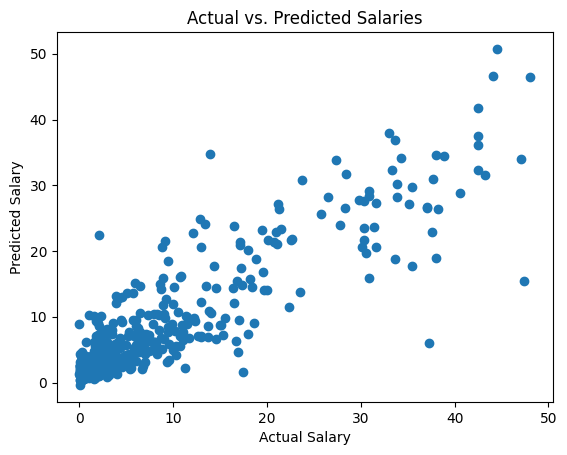

In [ ]:
#compare actual vs. predicted
plt.scatter(y_tensor, preds)
plt.xlabel('Actual Salary')
plt.ylabel('Predicted Salary')
plt.title('Actual vs. Predicted Salaries')
plt.show()

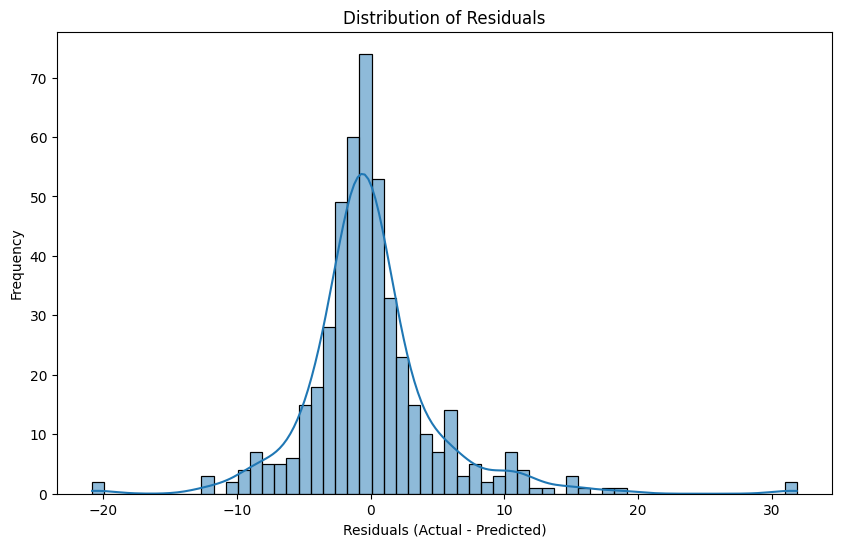

In [ ]:
residuals = y_tensor.squeeze().numpy() - preds.squeeze().numpy()

plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals (Actual - Predicted)')
plt.ylabel('Frequency')
plt.show()